# MLP with sentence level embedding

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import torch 
import torch.nn.functional as F

In [2]:
papers = pd.read_csv("data/sci_papers.csv")

In [3]:
df = papers
counts = df["category"].value_counts()
categories = df.category.unique()
others = counts.index[5:].tolist()
df.loc[df['category'].isin(others), 'category'] = 'others'


In [4]:
titles = df["title"]

# Create a list of all unique words by splitting titles into words and using set
unique_words = set()
for title in titles:
    # Split each title into words and convert to lowercase
    words = ''.join(char.lower() for char in title if char.isalnum() or char.isspace()).split()
    unique_words.update(words)

# Convert set back to list for easier manipulation
vocab = sorted(list(unique_words))
len(vocab)

63800

Each word is embbeded with a emb_dim dimensional vector. 

The sentence is represented by a vector of size emb_dim, which is the coordonate by coordonate average of the word vectors.

The sentence vector is then passed to a MLP 


In [131]:
# each word is embbeded in a emb_dim dimension space
# So each title is embbeded as a list of word embeddings 
# As each title has a different length we will resort to pooling methods

categories = df.category.unique()

wtoi = {t:i for i,t in enumerate(vocab)} # word to integer 
itow = {i:t for i,t in enumerate(vocab)} # integer to word

ttoi = {t:i for i,t in enumerate(titles)} # title to integer 
itot = {i:t for i,t in enumerate(titles)} # integer to title

ctoi = {c:i for i,c in enumerate(categories)} # category to integer
itoc = {i:c for i,c in enumerate(categories)} # integer to category


In [35]:
emb_dim = 30
C = torch.randn((len(vocab), emb_dim))
C[0]

tensor([-0.6153,  0.5259, -0.8577, -0.8295, -0.7789, -0.7647,  0.9504,  0.6444,
        -2.1112,  0.6415,  0.8978, -2.2323, -0.3458,  0.7734, -1.8219,  0.0540,
         0.2682, -1.5159,  0.3070,  1.2846, -0.0076,  1.4525, -1.4885, -2.0725,
         1.3749,  1.0636,  3.3695,  0.3144, -0.8884, -0.6175])

In [ ]:

emb_titles = []
for t in titles:
    t_clean = ''.join(char.lower() if char.isalnum() or char.isspace() else '' for char in t)
    words = t_clean.split()

    indices = [wtoi[w] for w in words if w in wtoi]
    word_embeddings = C[indices] # (nbr_words_in_title, emb_dim)
    avg_embedding = word_embeddings.mean(dim=0) # mean 
    
    emb_titles.append(avg_embedding)

emb_titles = torch.stack(emb_titles)
emb_titles.shape # (nbr_titles, emb_dim)

In [157]:
def titles_embbeding(titles, C, poolingtype="avg"): 
    titles_emb = []
    for t in titles:
        t_clean = ''.join(char.lower() if char.isalnum() or char.isspace() else '' for char in t)
        words = t_clean.split()

        indices = [wtoi[w] for w in words if w in wtoi]
        word_embeddings = C[indices] # (nbr_words_in_title, emb_dim)
        if poolingtype == "avg":
            emb = word_embeddings.mean(dim=0) # mean 
        elif poolingtype == "max":
            emb = word_embeddings.max(dim=0)
        else:
            print("Choose between 'avg' and 'max'")
        titles_emb.append(emb)

    titles_emb = torch.stack(titles_emb)
    return titles_emb

In [52]:
print(emb_titles[0])  # prints the embedding of the first title

t_clean = ''.join(char.lower() if char.isalnum() or char.isspace() else '' for char in titles[0])
words = t_clean.split()
word_embeddings = torch.stack([C[wtoi[w]] for w in words])
print(word_embeddings)  # prints embeddings of each word in the first title
print(torch.mean(word_embeddings, dim=0))  # prints the mean embedding across all words$

# we see that the mean pooling works
# In this simple example (2 words) we see that the embedded title is the coordinate-wise mean of the embedded words

# Now, we can train an MLP with the input beeing a title embbeding 

tensor([-0.7358, -0.4954,  0.9357,  0.2470, -0.9818,  0.1556, -0.8622,  1.9042,
        -0.9372, -0.3247, -0.9486, -1.4173, -0.2634, -1.0253, -1.0854, -1.8456,
        -0.7672, -0.4807, -0.6087,  0.3431, -0.1922, -0.0295,  0.5408,  0.5881,
         0.4310,  1.2848,  1.2635, -0.1438, -0.6674, -0.0533])
tensor([[-0.5071, -1.6392,  0.6542,  0.2879, -1.0984,  0.4662, -0.6844,  0.5417,
         -0.3268, -0.8851, -0.8513, -0.9094, -0.1195,  0.1104, -0.9749, -1.1119,
         -1.3838,  0.2454, -1.3529,  0.2864,  0.4461,  0.8756,  1.3577,  1.5708,
          0.5058,  1.2058,  2.0327, -0.0757,  0.7134, -0.3757],
        [-0.9646,  0.6484,  1.2173,  0.2061, -0.8652, -0.1550, -1.0400,  3.2666,
         -1.5476,  0.2356, -1.0459, -1.9252, -0.4073, -2.1610, -1.1958, -2.5793,
         -0.1507, -1.2069,  0.1355,  0.3998, -0.8305, -0.9345, -0.2761, -0.3946,
          0.3562,  1.3638,  0.4942, -0.2119, -2.0482,  0.2692]])
tensor([-0.7358, -0.4954,  0.9357,  0.2470, -0.9818,  0.1556, -0.8622,  1.9042,
  

In [53]:

def build_dataset(papers):  
    X = torch.arange(0, papers.shape[0])
    Y = torch.tensor([ctoi[df["category"][i]] for i in range(0, papers.shape[0])])
    #print(X.shape, Y.shape)
    return X, Y

build_dataset(df[:10])

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [54]:
import random
random.seed(42)
indices = list(range(len(papers)))
random.shuffle(indices)
papers_shuffled = papers.iloc[indices].reset_index(drop=True) # shuffled dataset 
n1 = int(0.8*len(papers_shuffled))
n2 = int(0.9*len(papers_shuffled))
Xtr, Ytr = build_dataset(papers_shuffled[:n1])
Xdev, Ydev = build_dataset(papers_shuffled[n1:n2])
Xte, Yte = build_dataset(papers_shuffled[n2:])

In [158]:
nbr_added_layers = 1
nbr_neurons_hidden = [256 for _ in range(nbr_added_layers)]
nbr_neurons_first = 256
nbr_categories = len(categories)
nbr_titles = len(titles)
vocab_size = len(vocab)
emb_dim = 10

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim, nbr_neurons_first), generator=g) / nbr_neurons_first**0.5 # kaiming init
b1 = torch.randn(nbr_neurons_first, generator=g) * 0.1

Ws = []
bs = []
parameters = [C, W1, b1]
for i in range(0, nbr_added_layers):
    if i == 0:
        W = torch.randn((nbr_neurons_first, nbr_neurons_hidden[i]), generator=g) / nbr_neurons_hidden[i]**0.5
    else : 
        W = torch.randn((nbr_neurons_hidden[i], nbr_neurons_hidden[i]), generator=g) / nbr_neurons_hidden[i]**0.5
    
    b = torch.randn(nbr_neurons_hidden[i], generator=g) * 0.1
    parameters.append(W)
    parameters.append(b)
    Ws.append(W)
    bs.append(b)

Wlast = torch.randn((nbr_neurons_hidden[-1], nbr_categories), generator=g) / nbr_neurons_hidden[-1]**0.5
blast = torch.randn((nbr_categories), generator=g) * 0.1

parameters.append(Wlast)
parameters.append(blast)

for p in parameters:
    print(p.shape)

print(sum(p.nelement() for p in parameters))

torch.Size([63800, 10])
torch.Size([10, 256])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([256, 6])
torch.Size([6])
708150


In [160]:
for p in parameters:
        p.requires_grad = True 
stepi, lossi, lri = [], [], []

In [166]:
n = 40000
batch_size = 30
lre = torch.linspace(-3, 0, n)
lrs = 10**lre #from 0.001 to 1 exponentielly stepped 

for i in range(n):
    # minibatch construct 
    ixs = torch.randint(0, Xtr.shape[0], (batch_size,)) 

    # Get the titles for these indices
    batch_titles = [itot[i.item()] for i in ixs]
    
    # Calculate embeddings for these titles using average pooling
    emb = titles_embbeding(batch_titles, C)
    
    # Forward pass through the network
    x = torch.tanh(emb @ W1 + b1)  
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    loss = F.cross_entropy(logits,Ytr[ixs]) 

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Use modulo to cycle through learning rates
    #lr = lrs[i % len(lrs)]
    #lr = 0.1 if i<0.9*n else 0.01
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad 

    stepi.append(i)
    #lri.append(lr.item())
    lossi.append(loss.item())


In [ ]:
def deep_model_test(X,Y):
    # Get the titles for these indices
    batch_titles = [itot[i.item()] for i in X]
    
    # Stack all embeddings into a single tensor
    emb = titles_embbeding(batch_titles, C)
    
    # Forward pass through the network
    x = torch.tanh(emb @ W1 + b1)  
    for W, b in zip(Ws, bs): 
        x = torch.tanh(x @ W + b)
    logits = x @ Wlast + blast
    loss = F.cross_entropy(logits,Y) 


    return loss

ldev = deep_model_test(Xdev, Ydev)
ltest = deep_model_test(Xte, Yte)
ltrain = deep_model_test(Xtr, Ytr)
print("ltrain : ", ltrain)
print("dev : ", ldev)
print("test : ", ltest)

# with 60k iterations (avg_pooling, emb_dim = 10, 1 hidden layer, 256 neurons per layer)
#ltrain :  tensor(1.1399, grad_fn=<NllLossBackward0>)
#dev :  tensor(1.5250, grad_fn=<NllLossBackward0>)
#test :  tensor(1.5250, grad_fn=<NllLossBackward0>)
# and the loss isn't platauing 

ltrain :  tensor(1.1399, grad_fn=<NllLossBackward0>)
dev :  tensor(1.5250, grad_fn=<NllLossBackward0>)
test :  tensor(1.5250, grad_fn=<NllLossBackward0>)


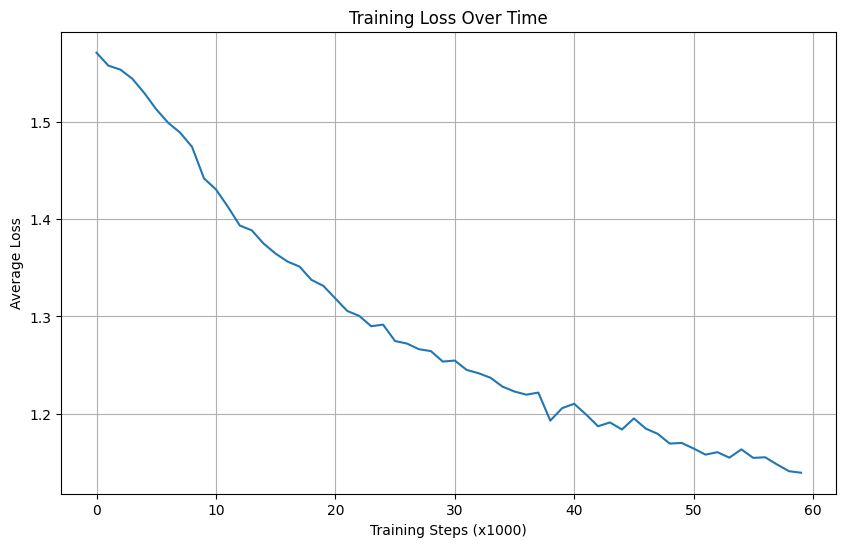

In [168]:
# Plot 1: Loss over training iterations (averaged over a window size)
window_size = 1000  # adjust this value to get smoother/rougher plot
plt.figure(figsize=(10, 6))
losses = torch.tensor(lossi)
n = len(losses)
n_windows = n // window_size
averaged_losses = losses[:n_windows * window_size].view(-1, window_size).mean(1)


plt.plot(torch.tensor(lossi).view(-1, window_size).mean(1))
plt.xlabel(f'Training Steps (x{window_size})')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

# Plot 2: Loss vs Learning Rate (averaged over 100 iterations)
# plt.figure()
# plt.plot(torch.tensor(lri).view(-1, 100).mean(1), torch.tensor(lossi).view(-1, 100).mean(1))
# plt.xlabel('Learning Rate')
# plt.ylabel('Average Loss')
# plt.title('Loss vs Learning Rate')
# plt.xscale('log')  # Learning rate is typically better viewed in log scale
# plt.grid(True)
# plt.show()

In [156]:
# forward
batch_titles = [itot[i.item()] for i in Xte]
emb = titles_embbeding(batch_titles)

x = torch.tanh(emb @ W1 + b1)  
for W, b in zip(Ws, bs): 
    x = torch.tanh(x @ W + b)
logits = x @ Wlast + blast
probs = F.softmax(logits, dim=1)

# Display last 5 results
print("5 papers predictions:")
indices = torch.randint(0, len(papers_shuffled.iloc[n2:]), (5,))
for idx in indices:
    print("\nTitle:", papers_shuffled.iloc[n2:].iloc[idx.item()]['title'])
    print("True category:", papers_shuffled.iloc[n2:].iloc[idx.item()]['category'])
    print("\nPredicted probabilities:")
    # Sort probabilities in descending order and get corresponding categories
    sorted_probs = [(prob.item(), cat) for prob, cat in zip(probs[idx.item()], categories)]
    sorted_probs.sort(reverse=True)
    for prob, cat in sorted_probs:
        print(f"{cat}: {prob*100:.2f}%")

5 papers predictions:

Title: A Generalization of Otsu's Method and Minimum Error Thresholding
True category: Computer Vision and Pattern Recognition

Predicted probabilities:
Machine Learning: 31.21%
Computer Vision and Pattern Recognition: 18.67%
Artificial Intelligence: 17.26%
Computation and Language (Natural Language Processing): 16.59%
others: 12.91%
Machine Learning (Statistics): 3.35%

Title: A Web Scale Entity Extraction System
True category: Computation and Language (Natural Language Processing)

Predicted probabilities:
Machine Learning: 28.16%
others: 26.75%
Artificial Intelligence: 21.91%
Computer Vision and Pattern Recognition: 15.31%
Machine Learning (Statistics): 5.96%
Computation and Language (Natural Language Processing): 1.92%

Title: A Large-scale Attribute Dataset for Zero-shot Learning
True category: Computer Vision and Pattern Recognition

Predicted probabilities:
Artificial Intelligence: 72.59%
others: 18.41%
Machine Learning: 4.01%
Computation and Language (Nat

### Conclusion : 

We beat the word embedding model without any optimization and with a smaller model. 